Image classification : binary problem

If cells are contaminated with mycoplasma probability is close to 1,
if cells are not infected probability is close to 0.

Contaminated cells labeled with : 1
No infected cells labeled with : 0

### Biblioteki i Pakiety

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical, normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping #??????
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Wczytywanie Katalogów ze Zdjęciami

In [2]:
# ścieżki do katalogów z obrazami komórek z mykoplazmą (positive) i bez mykoplazmy (negative)
positive_directory = r"C:\Users\IgA\Documents\Machine_learning_Chemia\mycoplasma\all\positive"
negative_directory = r"C:\Users\IgA\Documents\Machine_learning_Chemia\mycoplasma\all\negative"

# sprawdzanie czy ścieżki do folderów są prawidłowe i jakie pliki się w nich znajdują
def check_directory(directory, name):
    if not os.path.exists(directory):
        print(f"Ścieżka do folderu {name} NIE jest prawidłowa")
    else:
        print(f"Ścieżka do folderu {name} JEST PRAWIDŁOWA")
        print('----------------------------------------------')
        print(f"Pliki w katalogu '{name}':")
        print(os.listdir(directory))  # Wyświetlenie zawartości katalogu

# printowanie wyników
check_directory(positive_directory, "positive")
print()
print()
check_directory(negative_directory, "negative")

Ścieżka do folderu positive JEST PRAWIDŁOWA
----------------------------------------------
Pliki w katalogu 'positive':
['mycoplasma_positive_1.jpg', 'mycoplasma_positive_1_90.jpg', 'mycoplasma_positive_1_reversed.jpg', 'mycoplasma_positive_2.jpg', 'mycoplasma_positive_2_90.jpg', 'mycoplasma_positive_2_reversed.jpg', 'mycoplasma_positive_3.jpg', 'mycoplasma_positive_3_90.jpg', 'mycoplasma_positive_3_reversed.jpg', 'mycoplasma_positive_4.jpg', 'mycoplasma_positive_4_90.jpg', 'mycoplasma_positive_4_reversed.jpg', 'mycoplasma_positive_5.jpg', 'mycoplasma_positive_5_90.jpg', 'mycoplasma_positive_5_reversed.jpg', 'mycoplasma_positive_6.jpg', 'mycoplasma_positive_6_90.jpg', 'mycoplasma_positive_6_reversed.jpg', 'positive_labels.json']


Ścieżka do folderu negative JEST PRAWIDŁOWA
----------------------------------------------
Pliki w katalogu 'negative':
['mycoplasma_negative_1.jpg', 'mycoplasma_negative_1_90.jpg', 'mycoplasma_negative_1_reversed.jpg', 'mycoplasma_negative_2.jpg', 'mycoplasm

### Docelowe Wymiary Obrazów i Utworzenie List

In [3]:
# wymiary do których obrazy zostaną przekształcone (wszystkie muszą mieć takie same wymiary a tu mają inne)
width = 400
height = 300

# listy do przechowywania kolejno obrazów i etykiet
images = []
labels = []

### Zmiana Rozmiarów Obrazów i Dodanie Etykiet

In [4]:
# określenie w którym katalogu znajdują się komórki zakażone mykoplazmą a w którym zdrowe
mycoplasma_positive = os.listdir(positive_directory)
mycoplasma_negative = os.listdir(negative_directory)

# przypisanie klas zdjęciom (1 - komórki zakażone, 0 - komórki zdrowe) i ich przekształcenie
for directory, class_label in [(positive_directory, 1), (negative_directory, 0)]:
    image_names = os.listdir(directory)
    for image_name in image_names:
        if image_name.endswith('.jpg'):
            image_path = os.path.join(directory, image_name)
            image = cv2.imread(image_path)
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'RGB')
            image_size = image.resize((width, height))
            images.append(np.array(image_size))
            labels.append(class_label)

In [5]:
# konwersja list na tablice NumPy
dataset = np.array(images)
labels = np.array(labels)

# sprawdzenie ile mamy obrazów i czy przypisane zostały im labele
print("Number of images in dataset:", len(dataset))
print("Number of labels in dataset:", len(labels))  

Number of images in dataset: 36
Number of labels in dataset: 36


In [6]:
# podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.20, random_state = 42)

# normalizacja danych wzdłuż wierszy
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

In [7]:
# przygotowanie konwolucyjnej sieci neuronowej (CNN) z użyciem Keras

# określenie wymiarów wejściowych obrazów (zdefiniowane wcześniej)
input_shapes = (width, height, 3)

# pierwsza warstwa wejściowa
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = input_shapes))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# druga warstwa wejściowa
model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# trzecia warstwa wejściowa
model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# spłaszczenie warstw konwolucyjnych w jednowymiarowy wektor
model.add(Flatten())

# warstwa gęsta
model.add(Dense(64))
model.add(Activation('relu'))

# regularyzacja by zapobiec przeuczeniu modelu (tu wybrane 50%)
model.add(Dropout(0.5))

# warstwa wyjściowa - funkcja sigmoidalna sprawia że wyniki znajdują się w zakresie (0, 1)
model.add(Dense(1))
model.add(Activation('sigmoid'))

# kompilacja modelu
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

print(model.summary())

C:\Users\IgA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 398, 298, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 147, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 197, 147, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 96, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 107520)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,881,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,910,049 (26.36 MB)

 Trainable params: 6,910,049 (26.36 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
# trenowanie modelu na danych treningowych
history = model.fit(
    X_train,
    y_train,
    batch_size = 16,
    verbose = 1, #2 dla bardziej szczegółowych informacji, 0 dla braku
    epochs = 50,
    validation_data = (X_test, y_test),
    shuffle = False,         
    )

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3393 - loss: 1.3917 - val_accuracy: 0.6250 - val_loss: 1.1603
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 495ms/step - accuracy: 0.4107 - loss: 1.4135 - val_accuracy: 0.6250 - val_loss: 0.5875
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step - accuracy: 0.5060 - loss: 0.7633 - val_accuracy: 0.6250 - val_loss: 0.5938
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - accuracy: 0.3899 - loss: 0.6766 - val_accuracy: 0.6250 - val_loss: 0.5874
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step - accuracy: 0.6429 - loss: 0.6285 - val_accuracy: 0.6250 - val_loss: 0.5678
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step - accuracy: 0.7083 - loss: 0.5876 - val_accuracy: 0.6250 - val_loss: 0.5633
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step - accuracy: 0.6190 - loss: 0.5275 - val_accuracy: 0.6250 - val_loss: 0.5362
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - accuracy: 0.7976 - loss: 0.4517 - val_accuracy: 0.6250 - val_loss: 0.

In [9]:
# zapisanie wyuczonego modelu
model.save('mycoplasma_model.h5')

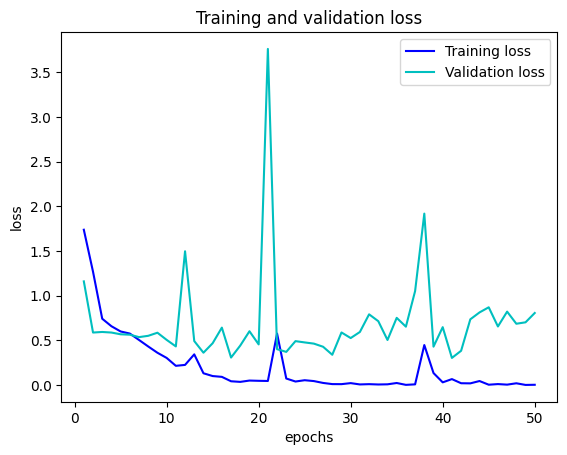

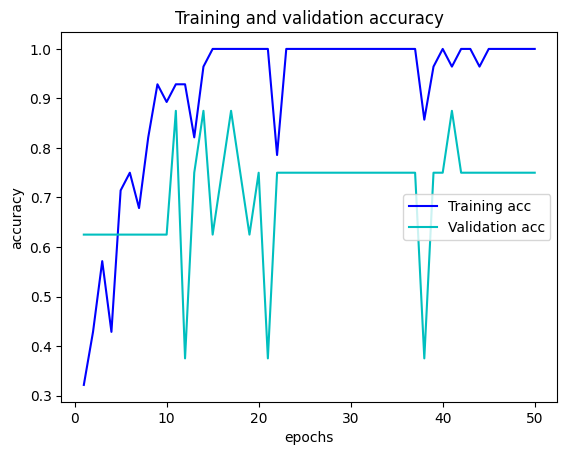

In [10]:
# określenie straty podczas uczenia modelu - określenie jak dobrze model dopasowuje się do danych treningowych
loss = history.history['loss']

# określenie straty na danych walidacyjnych - jak model działa na danych walidacyjnych których nie widział w czasie treningu
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# wykres : training and validation loss
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'c', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# dokładności obliczone dla danych treningowych a następnie walidacyjnych
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# wykres : training and validation accuracy
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'c', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction:  [[0.99821764]]
Real label:  1


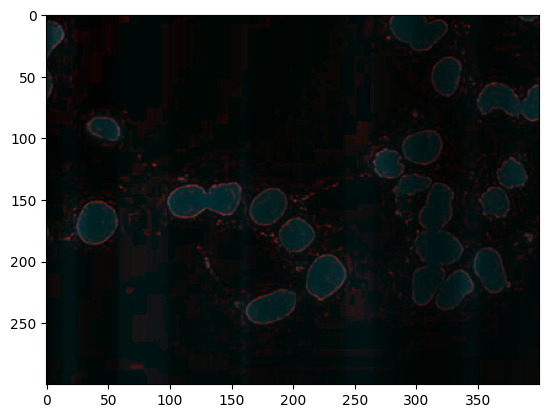

In [15]:
# wyświetlenie wybranego obrazu ze zbioru testowego
n=4
img = X_test[n]
plt.imshow(img)

# użycie modelu do sprawdzenia klasy obrazu i porównanie jej z rzeczywistą klasą
input_img = np.expand_dims(img, axis = 0)
print('Prediction: ', model.predict(input_img))
print('Real label: ', y_test[n])

In [12]:
_, acc = model.evaluate(X_test, y_test)
print('accuracy: ', (acc * 100.0), '%')

#sensitivity
#specificity
#precision
#recall

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7500 - loss: 0.8062
accuracy:  75.0 %


### Confusion Matrix

In [13]:
# ustalenie thresholdu - progu klasyfikacji 
mythreshold = 0.48
from sklearn.metrics import confusion_matrix

# przewidzenie idealnego thresholdu
i = np.arange(len(tpr))
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
print("Ideal threshold: ", ideal_roc_thresh['thresholds'])

NameError: name 'tpr' is not defined

In [230]:
print(roc)

         tf    thresholds
0 -1.000000  2.000000e+00
1 -0.777778  1.000000e+00
2 -0.333333  9.999999e-01
3 -0.222222  9.999999e-01
4  0.000000  4.815139e-01
5  0.333333  2.553520e-01
6  1.000000  1.973462e-07


In [225]:
# obliczenie macierzy pomyłek z wybranych thresholdem
y_pred = (model.predict(X_test) >= mythreshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
[[6 0]
 [0 9]]


### ROC

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


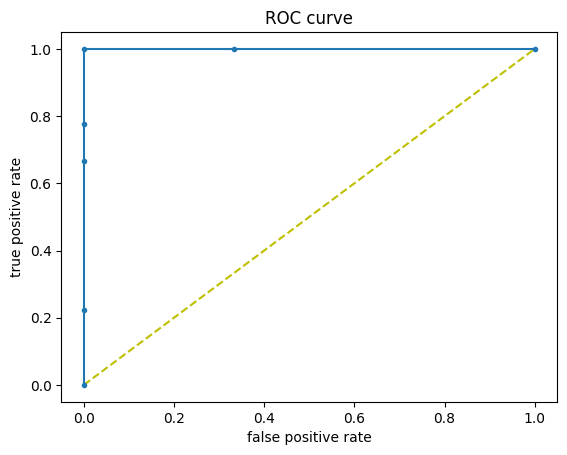

Area under curve, AUC =  1.0


In [232]:
# obliczenie i zwizualizowanie krzywej ROC
y_preds = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker = '.')
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

# obliczenie wartości AUC
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [234]:
y_preds = model.predict(X_test).ravel()
print(y_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
[9.9999994e-01 8.9180809e-05 2.5535196e-01 1.0000000e+00 1.9734624e-07
 9.9999994e-01 9.9999988e-01 4.6864065e-07 9.9999994e-01 2.5535196e-01
 1.0000000e+00 2.6159046e-06 4.8151395e-01 4.8151395e-01 9.9999994e-01]
